In [7]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

table = pd.read_csv('/home/jovyan/work/prj_data/open/train.csv')
data_root = '/home/jovyan/work/prj_data/open'
save_root = '/home/jovyan/work/work_space/uijin/temp_anno/'
for id, mask_rle in tqdm(zip(table['img_id'], table['mask_rle'])):
    img_name = data_root + '/train_img/' + id + '.png'
    img = np.asarray(Image.open(img_name))
    mask = rle_decode(mask_rle, (img.shape[0], img.shape[1]))
    cv2.imwrite(save_root + id + '.png', mask)
    break

7140it [06:01, 19.76it/s]


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

data_root = '/home/jovyan/work/datasets/satellite/split_anno_val'
save_root = '/home/jovyan/work/datasets/satellite/annotations/validation/'
for img_name in tqdm(os.listdir(data_root)):
    if img_name[-3:] == "png":
        img_path = os.path.join(data_root, img_name)
        img = cv2.imread(img_path, 0)
        cv2.imwrite(save_root + img_name, img)

100%|██████████| 1428/1428 [00:24<00:00, 59.23it/s]


In [5]:
cv2.imread("/home/jovyan/work/datasets/satellite/annotations/validation/TRAIN_0001.png", -1).shape

(1024, 1024)

In [16]:
for img in os.listdir(data_root):
    if img[-3:] != "png":
        print(img)

.ipynb_checkpoints


Loads checkpoint by local backend from path: /home/jovyan/work/work_space/uijin/submit/mmseg/ckpts/test.pth


  0%|          | 0/60640 [00:02<?, ?it/s]


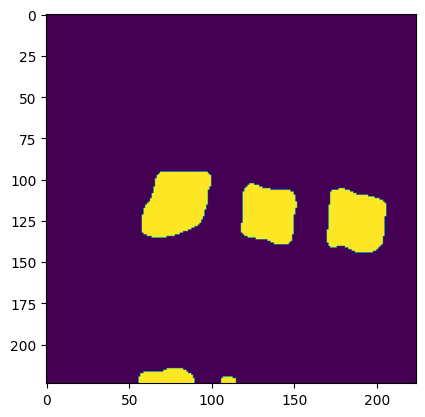

In [3]:
import os
import mmcv
import torch
from tqdm import tqdm
# from mmcv.parallel import MMDataParallel
from argparse import ArgumentParser
from mmseg.apis import init_model, inference_model

import pandas as pd
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def main():
    save_dir = "/home/jovyan/work/work_space/uijin/submit/mmseg"
    file_name = "test"
    sample_path = "/home/jovyan/work/work_space/uijin/submit/sample_submission.csv"
    test_image_path = "/home/jovyan/work/datasets/satellite/images/test"
    device = "cuda:1"
    config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
  
    ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
        
        
    model = init_model(config_path, ckpt_path, device)
    # model = MMDataParallel(model.cuda(), device_ids=[0])
    data = pd.read_csv(sample_path)['img_id'].values.tolist()
    
    with torch.no_grad():
        model.eval()
        result = []
        for img_id in tqdm(data):
            img_path = os.path.join(test_image_path, img_id + ".png")
            mask = inference_model(model, img_path)
            mask = mask.pred_sem_seg.data
            mask =torch.squeeze(mask).cpu().numpy()
            
            plt.imshow(mask)
            break
            # mask_rle = rle_encode(mask)
            # if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
            #     result.append(-1)
            # else:
            #     result.append(mask_rle)

    # submit = pd.read_csv(sample_path)
    # submit['mask_rle'] = result
    # submit.to_csv(os.path.join(save_dir, file_name + '.csv'), index=False)

if __name__ == '__main__':
    main()

/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /home/jovyan/work/work_space/uijin/submit/mmseg/ckpts/deeplabv3p_re.pth


  0%|          | 0/60640 [00:00<?, ?it/s]

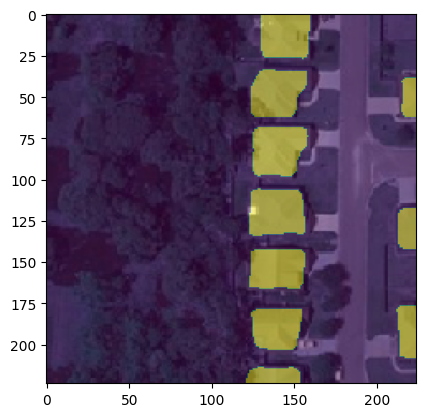

  0%|          | 0/60640 [00:00<?, ?it/s]


In [8]:
import os
import cv2
import mmcv
import torch
from tqdm import tqdm
# from mmcv.parallel import MMDataParallel

from argparse import ArgumentParser
from mmseg.apis import init_model, inference_model
from torchvision.transforms import Resize

import pandas as pd
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def main():
    file_name = "deeplabv3p_re"
    sample_path = "/home/jovyan/work/work_space/uijin/submit/sample_submission.csv"
    test_image_path = "/home/jovyan/work/datasets/satellite/images/test"
    device = "cuda:1"
    config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
    ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
    img_ratios = [0.5, 1.0, 1.25, 1.5, 1.75, 2.0]
    threshold = 3
        
        
    model = init_model(config_path, ckpt_path, device)
    # model = MMDataParallel(model.cuda(), device_ids=[0])
    
    
    data = pd.read_csv(sample_path)['img_id'].values.tolist()
    with torch.no_grad():
        model.eval()
        result = []
        for img_id in tqdm(data):
            img_path = os.path.join(test_image_path, "TEST_03376" + ".png")
            img = cv2.imread(img_path)
            total_mask = np.zeros((img.shape[0], img.shape[1]))
            for ratio in img_ratios:
                resized_img = cv2.resize(img, dsize=(int(img.shape[0]*ratio), int(img.shape[1]*ratio)))
                mask = inference_model(model, resized_img)
                mask = mask.pred_sem_seg.data
                mask = torch.squeeze(mask).cpu().numpy()
                resized_mask = cv2.resize(mask.astype("float32"), dsize=(img.shape[0], img.shape[1]))
                total_mask += resized_mask
            total_mask[total_mask < threshold] = 0
            total_mask[total_mask >= threshold] = 1
            
            plt.imshow(img)
            plt.imshow(total_mask, alpha=0.5)
            mask_rle = rle_encode(total_mask)
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)
            plt.show()
            break
            

if __name__ == '__main__':
    main()

/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jovyan/work/work_space/uijin/mmseg/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /home/jovyan/work/work_space/uijin/submit/mmseg/ckpts/deeplabv3p_re.pth


/tmp/ipykernel_1967148/3913653341.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  i = torch.tensor([img1, img2, img3]).to(device)


torch.Size([3, 2, 56, 56])


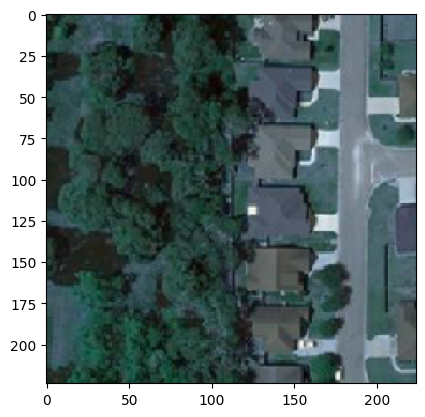

In [1]:
import os
import cv2
import mmcv
import torch
from tqdm import tqdm
# from mmcv.parallel import MMDataParallel

from argparse import ArgumentParser
from mmseg.apis import init_model, inference_model
from torchvision.transforms import Resize

import pandas as pd
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

file_name = "deeplabv3p_re"
sample_path = "/home/jovyan/work/work_space/uijin/submit/sample_submission.csv"
test_image_path = "/home/jovyan/work/datasets/satellite/images/test"
device = "cuda:0"# "cuda:0"
config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
img_ratios = [0.5, 1.0, 1.5, 2.0]
threshold = 2


model = init_model(config_path, ckpt_path, device)
# model = MMDataParallel(model.cuda(), device_ids=[0])

data = pd.read_csv(sample_path)['img_id'].values.tolist()
with torch.no_grad():
    model.eval()
    result = []
    img_path1 = os.path.join(test_image_path, "TEST_03376" + ".png")
    img_path2 = os.path.join(test_image_path, "TEST_03375" + ".png")
    img_path3 = os.path.join(test_image_path, "TEST_03374" + ".png")
    plt.imshow(cv2.imread(img_path1))
    img1 = np.transpose(cv2.imread(img_path1), (2, 1, 0)).astype(np.float32)
    img2 = np.transpose(cv2.imread(img_path2), (2, 1, 0)).astype(np.float32)
    img3 = np.transpose(cv2.imread(img_path3), (2, 1, 0)).astype(np.float32)
    i = torch.tensor([img1, img2, img3]).to(device)
    mask = model(i)
    print(mask.shape)

In [ ]:
# for name, param in model.named_parameters():
#     print(name,param.shape)
model

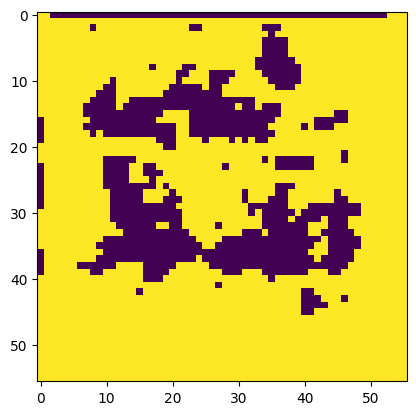

In [2]:
from torch.nn import Softmax, CrossEntropyLoss, BatchNorm2d
bn = BatchNorm2d(num_features=2).cuda()
crit = Softmax(dim=0)
a = bn(mask)
a = crit(a[0])
a
b = torch.round(a).cpu().detach().numpy()
plt.imshow(b[1])

In [ ]:
mask

In [ ]:
from torchsummary import summary
from mmseg.apis import init_model, inference_model
from torchvision.transforms import Resize

import json, os
import numpy as np
import matplotlib.pyplot as plt

file_name = "deeplabv3p_re"
device = "cuda:1"# "cuda:0"
config_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/configs', file_name+".py")  
ckpt_path = os.path.join('/home/jovyan/work/work_space/uijin/submit/mmseg/ckpts', file_name+".pth")
model = init_model(config_path, ckpt_path, device)
model = model.to(device)
summary(model, (3, 224, 224))

In [ ]:
print(mask[1])

In [30]:
import os, cv2
import mmcv
import torch
from tqdm import tqdm
# from mmcv.parallel import MMDataParallel
from argparse import ArgumentParser
from mmseg.apis import init_model, inference_model

import pandas as pd
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt

palette = np.array([[0, 0, 0], [0, 0, 255]])
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def check():
    check_dir = "/home/jovyan/work/prj_data/open/train_img"
    img_list = [f for f in os.listdir(check_dir) if os.path.splitext(f)[1] == ".png"]
    img_list.sort()
    anno_pd = pd.read_csv("/home/jovyan/work/prj_data/open/train.csv")
    save_dir = "/home/jovyan/work/work_space/data EDA/check_outlier"
    alpha = 0.65
    for img_name in tqdm(img_list):
        img_path = os.path.join(check_dir, img_name)
        img = cv2.imread(img_path)
        mask_rle = anno_pd[anno_pd["img_id"]==os.path.splitext(img_name)[0]]["mask_rle"].values.tolist()[0]
        mask = rle_decode(mask_rle, (img.shape[0], img.shape[1]))
        mask = palette[mask]
        blended = cv2.addWeighted(img, alpha, mask, (1-alpha), 0, dtype = cv2.CV_8U)
        cv2.imwrite(os.path.join(save_dir, img_name), blended)
        
check()
        

100%|██████████| 7140/7140 [15:40<00:00,  7.59it/s]  


In [ ]:
alpha = 0.5
blended1 = (img1 * alpha) + (img2 * (1-alpha))              # 방식1
blended1 = blended1.astype(np.uint8) # 소수점 제거
blended2 = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) # 방식2
